# NASDAQ Stock Indices

#### March 2017
<u>Statistics 141B:</u> Data and Web Technologies<br>
<u>Contributors:</u> Jeremy Weidner, Weizhou Wang, Audrey Chu, and Yuji Mori

### I. Abstract

To study NASDAQ stock prices for the technology, finance, health care, and energy industry sectors across time.  With the application of python and utilization of the Yahoo! Finance API, Yahoo Query Language (YQL), and New York Times API, we will gather and clean out a dataset for a time period of ten years for approximately 1770 companies.  Our data will incorporate the closing prices for each day and then average these prices for each respective sector.  In analyzing the stock prices, we will use interactive data visualization as well as attempt to create a time series ARIMA (Autoregressive Integrated Moving Average) model.

### II. Questions of Interest
- How do stock prices differ among industry sectors?
- Can we explain unusual trends in past prices by relating them to major historical events?
- Which month for which sector has the least volatility?

In [2]:
import sys
import csv
import json
import requests
import requests_cache
import numpy as np
import pandas as pd
#from yahoo_finance import Share
from pprint import pprint 
from datetime import datetime
import matplotlib.pyplot as plt
import math

import matplotlib as mpl
%matplotlib inline

import seaborn as sns
sns.set_style('white', {"xtick.major.size": 2, "ytick.major.size": 2})
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71","#f4cae4"]
sns.set_palette(sns.color_palette(flatui,7))

import missingno as msno

#this is for time series
from  __future__ import print_function
from scipy import stats
import statsmodels.api as sm
from statsmodels.graphics.api import qqplot

#this is for plotting the prices
import plotly
plotly.tools.set_credentials_file(username="audchu",api_key="fPSZjEJ6wqYjzolZ8wNI")
import plotly.plotly as py
import plotly.graph_objs as go
from datetime import datetime
from pandas_datareader import data,wb

#this is for streaming plot
from plotly.grid_objs import Grid,Column
import time

In [3]:
requests_cache.install_cache('cache')

In [4]:
# Yahoo! YQL API
PUBLIC_API_URL = 'https://query.yahooapis.com/v1/public/yql'
OAUTH_API_URL = 'https://query.yahooapis.com/v1/yql'
DATATABLES_URL = 'store://datatables.org/alltableswithkeys'

def myreq(ticker, start, end):
    '''
    input ticker & dates as strings form 'YYYY-MM-DD'
    '''
    params = {'format':'json',
             'env':DATATABLES_URL}
    query = 'select * from yahoo.finance.historicaldata where symbol = "{}" and startDate = "{}" and endDate = "{}"'.format(ticker,start, end)
    params.update({'q':query})
    req = requests.get(PUBLIC_API_URL, params=params)
    req.raise_for_status()
    req = req.json()
    if req['query']['count'] > 0:
        result = req['query']['results']['quote']
        return result
    else:
        pass

In [5]:
def price2(ticker):
    """
    Return closing prices for stocks from years 2006 to 2016.
    """
    
    date=[]
    price=[]
    report = []
    
    years = [2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016]
    for x in range(len(years)):
        c = myreq(ticker,'{}-01-01'.format(years[x]),'{}-12-31'.format(years[x]))
        try:
        
            for i in range(0,len(c)):
                date.append(pd.to_datetime(c[i]["Date"]))
                price.append(float(c[i][u'Close']))
                datef = pd.DataFrame(date)
                pricef = pd.DataFrame(price)
                table1 = pd.concat([datef,pricef],axis = 1)
                table1.columns = ['Date', ticker]
                table1 = table1.set_index("Date")
            
        except Exception:
            table1 = pd.DataFrame()
    
    return table1

In [6]:
csv = pd.read_csv('./companylist.csv')
# We want to keep "Finance, Health Care, Technology, Energy"
newcsv = csv[csv["Sector"].isin(["Finance", "Energy","Health Care","Technology"])].reset_index()
del newcsv["index"]

In [7]:
whole_list = newcsv['Symbol']

In [54]:
'''
for l in whole_list:
    get = price2(l)
    try:
        df = pd.concat([df,get],axis = 1)    # concat. by column 
    except NameError:
        df = pd.DataFrame(get)    # initialize automatically
# SAVE THE RESULT LOCALLY:
df.to_pickle('mydf')
'''

"\nfor l in whole_list:\n    get = price2(l)\n    try:\n        df = pd.concat([df,get],axis = 1)    # concat. by column \n    except NameError:\n        df = pd.DataFrame(get)    # initialize automatically\n# SAVE THE RESULT LOCALLY:\ndf.to_pickle('mydf')\n"

In [8]:
df = pd.read_pickle('mydf')

In [9]:
# This allows us to control size of a dataframe displayed to examine our data in depth
pd.options.display.max_columns = 20
pd.options.display.max_rows = 30

In [10]:
df.head()

,PIH,FCCY,SRCE,VNET,TWOU,JOBS,ABEO,ABIL,ABMD,AXAS,...,ZLTQ,ZN,ZION,ZIONW,ZIOP,ZIXI,ZGNX,ZSAN,ZYNE,ZNGA
Date,,,,,,,,,,,,,,,,,,,,,
2006-01-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-01-03,NaN,21.499973,25.830002,NaN,NaN,14.95,0.51,NaN,9.35,5.55,...,NaN,NaN,76.480003,NaN,3.60,1.93,NaN,NaN,NaN,NaN
2006-01-04,NaN,21.499973,25.659998,NaN,NaN,14.79,0.47,NaN,9.62,5.55,...,NaN,NaN,77.019997,NaN,4.00,2.04,NaN,NaN,NaN,NaN
2006-01-05,NaN,20.999980,25.820004,NaN,NaN,16.15,0.46,NaN,9.55,5.81,...,NaN,NaN,77.720001,NaN,4.00,2.20,NaN,NaN,NaN,NaN
2006-01-06,NaN,20.519969,25.950002,NaN,NaN,17.08,0.45,NaN,9.75,5.95,...,NaN,NaN,78.529999,NaN,4.25,2.09,NaN,NaN,NaN,NaN


In [11]:
final = newcsv.reset_index()
df_long = df.transpose()
sector  = final[['Symbol','Sector']]
sector = sector.set_index('Symbol')

In [12]:
final = df_long.join(sector)

In [14]:
final.head()

,2006-01-02 00:00:00,2006-01-03 00:00:00,2006-01-04 00:00:00,2006-01-05 00:00:00,2006-01-06 00:00:00,2006-01-09 00:00:00,2006-01-10 00:00:00,2006-01-11 00:00:00,2006-01-12 00:00:00,2006-01-13 00:00:00,...,2016-12-20 00:00:00,2016-12-21 00:00:00,2016-12-22 00:00:00,2016-12-23 00:00:00,2016-12-26 00:00:00,2016-12-27 00:00:00,2016-12-28 00:00:00,2016-12-29 00:00:00,2016-12-30 00:00:00,Sector
PIH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.601000,7.583000,7.400000,7.650000,NaN,7.400000,7.400000,7.250000,7.800000,Finance
FCCY,NaN,21.499973,21.499973,20.999980,20.519969,20.249976,19.999980,20.369968,20.000001,20.779999,...,17.549999,17.350000,17.280001,17.350000,NaN,18.100000,18.250000,18.000000,18.700001,Finance
SRCE,NaN,25.830002,25.659998,25.820004,25.950002,25.999997,25.999997,25.999997,25.940002,25.989997,...,45.000000,44.439999,44.400002,44.200001,NaN,44.740002,44.700001,45.330002,44.660000,Finance
VNET,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7.320000,7.100000,6.990000,7.050000,NaN,7.150000,7.090000,6.960000,7.010000,Technology
TWOU,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,33.049999,32.099998,30.740000,30.809999,NaN,30.549999,30.340000,29.770000,30.150000,Technology


In [15]:
hc = final[final['Sector'] == 'Health Care']

In [16]:
# take median within groups for each recorded date:
avg_sector = final.groupby('Sector').median().reset_index('Sector')
avg_sector = avg_sector.set_index('Sector')
avg_sector = avg_sector.dropna(thresh=4, axis = 1) # this drops if a column does not have at least two non NA's

In [17]:
# Dates as index for plotting
# This is basically the original DF (transposed and transposed back)
# but the columns are now the Sector averages.
avg_T = avg_sector.transpose()

In [18]:
avg_T.head()

Sector,Energy,Finance,Health Care,Technology
2006-01-03 00:00:00,13.565,23.250000,7.009993,11.245
2006-01-04 00:00:00,13.460,23.309999,6.930000,11.655
2006-01-05 00:00:00,13.750,23.459999,7.004996,11.770
2006-01-06 00:00:00,13.700,23.400000,7.033586,11.775
2006-01-09 00:00:00,13.790,23.500000,7.160000,12.050


In [19]:
def ts_slider(sector,sec_name):
    trace = go.Scatter(x=avg_T.index,y=sector)
    data = [trace]
    layout = dict(
        title=sec_name + ' Sector Closing Prices: Time series with Range Slider',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),
                    dict(count=1,
                        label='YTD',
                        step='year',
                        stepmode='todate'),
                    dict(count=1,
                        label='1y',
                        step='year',
                        stepmode='backward'),
                    dict(step='all')
                ])
            ),
            rangeslider=dict(),
            type='date'
        )
    )

    fig = dict(data=data, layout=layout)
    return py.iplot(fig)

In [20]:
ts_slider(avg_T.Energy,"Energy")

## Volatility Analysis

In [21]:
# A new DF for the difference between each day:
delta_df = pd.DataFrame()
for sect in avg_T.columns:
    delta_df[sect] = np.log(avg_T[sect].shift(1)) - np.log(avg_T[sect])
delta_df.columns = map(lambda name: '{} Changes'.format(name),avg_T.columns)

# On what day did the stock price spike the most?
abs(delta_df).idxmax()

Energy Changes        2008-10-06
Finance Changes       2008-12-01
Health Care Changes   2008-11-19
Technology Changes    2008-12-01
dtype: datetime64[ns]

In [22]:
shade = delta_df['Energy Changes']

In [23]:
delta_df.head()

,Energy Changes,Finance Changes,Health Care Changes,Technology Changes
2006-01-03,NaN,NaN,NaN,NaN
2006-01-04,0.007771,-0.002577,0.011477,-0.035812
2006-01-05,-0.021316,-0.006414,-0.010764,-0.009819
2006-01-06,0.003643,0.002561,-0.004073,-0.000425
2006-01-09,-0.006548,-0.004264,-0.017813,-0.023086


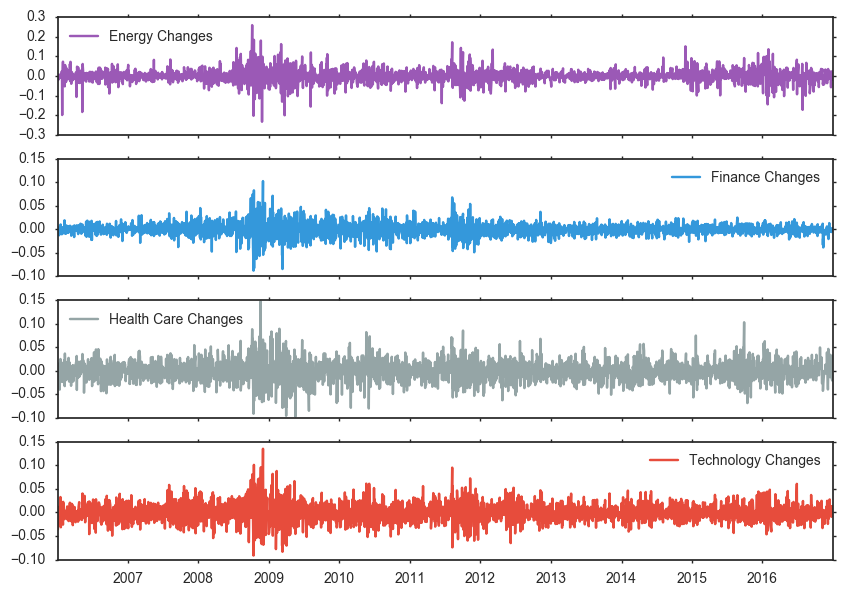

In [24]:
plot_cols = list(delta_df)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
delta_df[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])
plt.show()

In [22]:
peak = delta_df[(delta_df <= 0.10).any(axis=1)]

## Subset Data of Dataframe

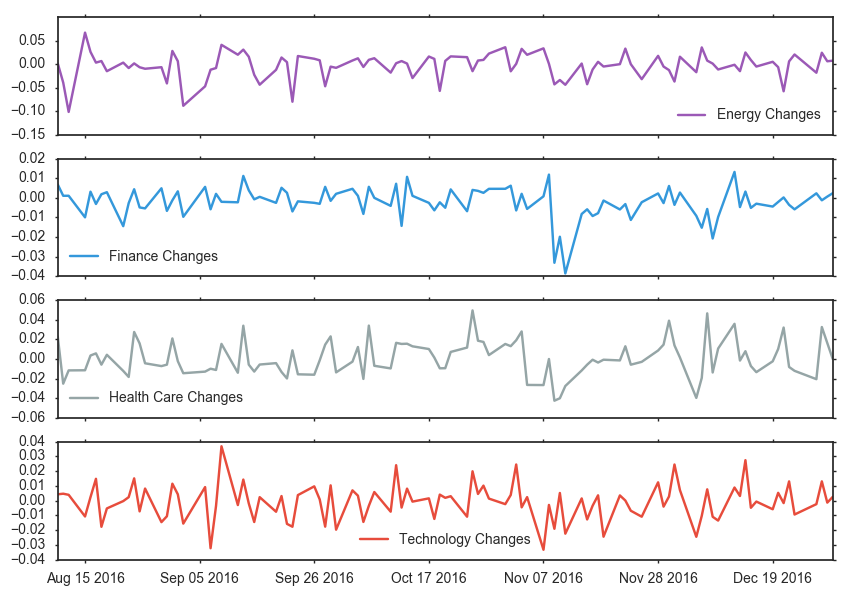

In [23]:
# 261 not right number, why is our last day 12-30-2016? -261 maybe?
year = delta_df.iloc[-100:,:]

plot_cols = list(year)

# 2 axes for 2 subplots
fig, axes = plt.subplots(4,1, figsize=(10,7), sharex=True)
#delta_df[plot_cols].plot(subplots=True, ax=axes)
year[plot_cols].plot(subplots=True, ax=axes)
#plt.ylim([-0.20,0.150])
plt.show()

#### Mega-function with everything related to the NYT API inside (work in progress)

In [68]:
from nytimesarticle import articleAPI
import time
api = articleAPI('2679a66fe8df4740b754f98e52ad068c')
def news_articles(sector,pages):
    sector_df = pd.DataFrame()
    for i in range(pages):
        try:
            if sector == 'Health Care':
                sector_articles = api.search( 
                    q = 'Health Care',
                    fq = {
                        'subject.contains':['Health', 'Care','Insurance','Drug'],
                        'type_of_material':'News'},
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                    )
            if sector == 'Technology':
                sector_articles = api.search(
                    q = 'Tech',
                    fq = {
                        'section_name':'Technology',
                        'subject.contains':'Mergers, Acquisitions and Divestitures',
                        'type_of_material':'News'
                        },
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Energy':
                sector_articles = api.search( 
                    q = 'stock',
                    fq = {
                        'subject.contains':['Energy','Oil','Renewable','Gas'],
                        'section_name':'Business Day',
                        'type_of_material':'News'
                        }, 
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                )
            if sector == 'Finance':
                sector_articles = api.search( 
                    q = 'stock',
                    fq = {
                        'subject.contains':['Bank','Financial','Loan'],
                        'section_name.contains':['Business','Finance'],
                        'type_of_material':'News'
                        }, 
                    begin_date = 20161101,
                    end_date = 20170301,
                    sort = 'oldest',
                    page = i
                )
            df_i = sector_articles['response']['docs']
            sector_df = sector_df.append(df_i) 
            time.sleep(1)   # API only allows 5 calls per second. This slows it down!
        except KeyError:
            break
        except IndexError:
            break
    return sector_df.reset_index()

In [69]:
# This stuff should be cached?
healthcare_news = news_articles('Health Care',30)

In [73]:
healthcare_news

,index,_id,abstract,blog,byline,document_type,headline,keywords,lead_paragraph,multimedia,...,print_page,pub_date,section_name,slideshow_credits,snippet,source,subsection_name,type_of_material,web_url,word_count
0,0,581875d195d0e022439c65f5,The Upshot; choosing health insurance is often...,[],"{u'person': [{u'organization': u'', u'role': u...",article,{u'main': u'Need to Pick an Insurance Plan? St...,[{u'value': u'Health Insurance and Managed Car...,Insurance is a hard product to buy. Here’s The...,"[{u'subtype': u'wide', u'url': u'images/2016/1...",...,3,2016-11-01T11:00:26Z,The Upshot,None,Insurance is a hard product to buy. Here’s The...,The New York Times,None,News,http://www.nytimes.com/2016/11/02/upshot/need-...,1466
1,1,581b660995d0e022439c6b7c,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,{u'main': u'Comparing Medicare Prescription Dr...,"[{u'value': u'Drugs (Pharmaceuticals)', u'is_m...",Experts advise those covered by Medicare to ch...,[],...,None,2016-11-02T22:35:29Z,Your Money,None,Experts advise those covered by Medicare to ch...,The New York Times,None,News,http://www.nytimes.com/2016/11/03/your-money/c...,727
2,2,581b762395d0e022439c6d7c,None,[],"{u'person': [{u'qualifier': u'M.D', u'firstnam...",article,{u'main': u'Think Like a Doctor: The Painter’s...,"[{u'value': u'Brain', u'is_major': u'N', u'ran...",What is causing this artist’s devastating head...,"[{u'subtype': u'wide', u'url': u'images/2016/1...",...,None,2016-11-03T14:00:08Z,Well,None,What is causing this artist’s devastating head...,The New York Times,Live,News,http://www.nytimes.com/2016/11/03/well/live/li...,1532
3,3,581c866695d0e01ffc1e179d,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,{u'main': u'See Obamacare Rates for Every Coun...,[{u'value': u'Health Insurance and Managed Car...,Prices are rising by an average of 22 percent ...,[],...,None,2016-11-04T13:00:14Z,The Upshot,None,Prices are rising by an average of 22 percent ...,The New York Times,None,News,http://www.nytimes.com/2016/11/05/upshot/see-o...,602
4,4,582100f695d0e0204d55f193,None,[],"{u'person': [{u'firstname': u'Jane', u'middlen...",article,"{u'main': u'After a Suicide Attempt, the Risk ...","[{u'value': u'Suicides and Suicide Attempts', ...",More than a million adults and 8 percent of hi...,"[{u'subtype': u'wide', u'url': u'images/2016/1...",...,5,2016-11-07T11:13:13Z,Well,None,More than a million adults and 8 percent of hi...,The New York Times,Live,News,http://www.nytimes.com/2016/11/08/well/live/af...,1082
5,5,582101bf95d0e0204d55f1cf,The Upshot; research suggests that United Stat...,[],{u'contributor': u'Aaron E. Carroll is a profe...,article,{u'main': u'A Doctor Shortage? Let’s Take a Cl...,"[{u'value': u'Doctors', u'is_major': u'Y', u'r...",Evidence suggests that the nation’s medical sy...,"[{u'subtype': u'wide', u'url': u'images/2016/1...",...,3,2016-11-07T12:30:06Z,The Upshot,None,Evidence suggests that the nation’s medical sy...,The New York Times,None,News,http://www.nytimes.com/2016/11/08/upshot/a-doc...,979
6,6,582105c995d0e0204d55f290,None,[],"{u'person': [{u'organization': u'', u'role': u...",article,{u'main': u'An Unfinished Presidency: Obama Pa...,"[{u'value': u'Obama, Barack', u'is_major': u'N...",As the nation prepares to choose President Oba...,[],...,2,2016-11-07T17:26:06Z,U.S.,None,As the nation prepares to choose President Oba...,The New York Times,Politics,News,http://www.nytimes.com/2016/11/08/us/politics/...,950
7,7,582105dd95d0e0204d55f299,Obama administration says it will step up enfo...,[],"{u'person': [{u'organization': u'', u'role': u...",article,{u'main': u'U.S. Enforcing Insurance Law to He...,[{u'value': u'Health Insurance and Managed Car...,"The move, intended to help fight opioid addict...","[{u'subtype': u'wide', u'url': u'images/2016/1...",...,10,2016-11-07T18:18:00Z,U.S.,None,"The move, intended to help fight opioid addict...",The New York Times,None,News,http://www.nytimes.com/2016/11/08/us/mental-he.

In [74]:
print healthcare_news.shape()

SyntaxError: invalid syntax (<ipython-input-74-25fe308a1074>, line 1)

In [27]:
tech_news = news_articles('Technology',10)

In [28]:
print tech_news.shape

(7, 21)


In [29]:
energy_news = news_articles('Energy',30)

In [30]:
finance_news = news_articles('Finance',10)

In [31]:
finance_news.shape

(30, 21)

In [32]:
health_labels = [d.get('main') for d in healthcare_news.headline]
health_x = list(pd.to_datetime(healthcare_news['pub_date']))
tech_labels = [d.get('main') for d in tech_news.headline]
tech_x = list(pd.to_datetime(tech_news['pub_date']))
energy_labels = [d.get('main') for d in energy_news.headline]
energy_x = list(pd.to_datetime(energy_news['pub_date']))
finance_labels = [d.get('main') for d in finance_news.headline]
finance_x = list(pd.to_datetime(finance_news['pub_date']))

headlines = health_labels+tech_labels+energy_labels+finance_labels
pub_dates = health_x+tech_x+energy_x+finance_x

date_range = [min(pub_dates),max(pub_dates)]
sector_level = [1]*len(health_x)+[2]*len(tech_x)+[3]*len(energy_x)+[4]*len(finance_x)

### Timeline:

NameError: name 'pub_dates' is not defined

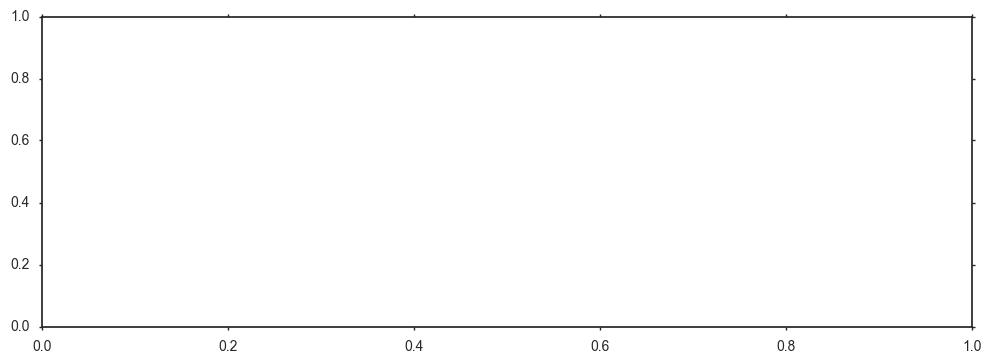

In [39]:
# how to create an interactive timeline
import mpld3
from mpld3 import plugins
# This is our attempt at creating an interactive "TIMELINE"
# we cannot figure out how to erase y-axis
fig, ax = plt.subplots(figsize=(12,4))
scatter = ax.scatter(pub_dates, sector_level,
           c=sector_level,marker='>', s=300)
fig.autofmt_xdate()
ax.set_xlim(date_range)
plt.yticks(range(6))
tooltip = plugins.PointLabelTooltip(scatter, headlines)
plugins.connect(fig, tooltip)
mpld3.display()

# Time Series Analysis

In [35]:
ts_eng = delta_df['Energy Changes']
# Why do we get an NA for Nov 1 2016?
# Need to change following date range
# ts_eng['2016-11-02':'2017-03-01']

## Check Stationarity

Dickey-Fuller Test: tests the null hypothesis of whether a u nit root is present in an autoregressive model.  

In [36]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput


test_stationarity(ts_eng)

In [44]:
testE = delta_df["Energy Changes"]

# Energy Sector Time Series

In [123]:
E_log = np.log(avg_T.iloc[-365:,:]['Health Care'])

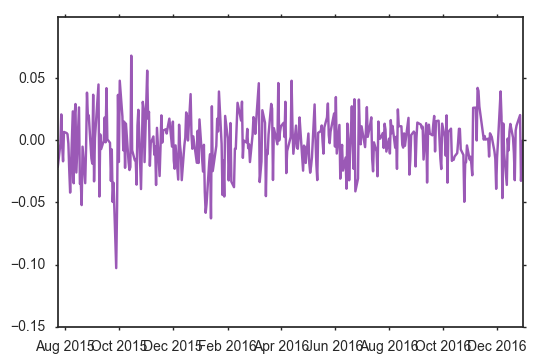

In [124]:
E_log_diff = E_log - E_log.shift()
plt.plot(E_log_diff)

(-0.15, 0.15)

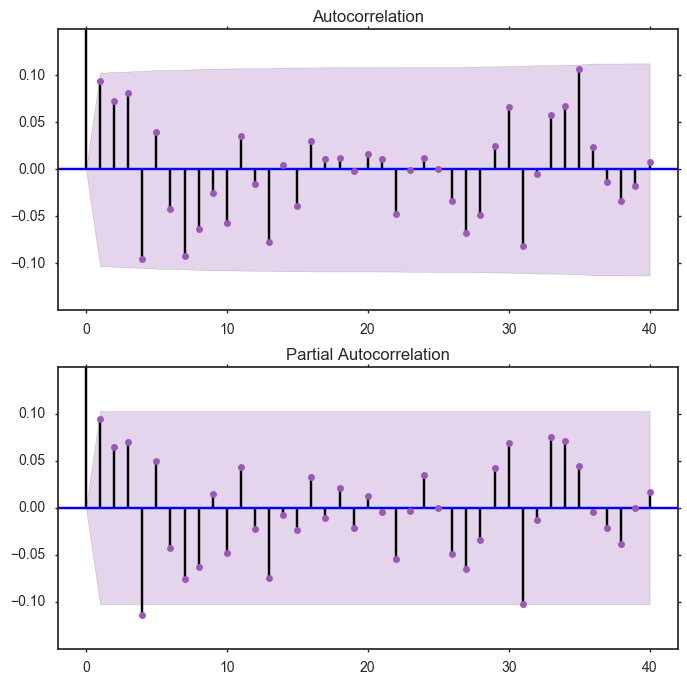

In [126]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211) 
fig = sm.graphics.tsa.plot_acf(E_log_diff[1:].values.squeeze(),lags = 40,ax=ax1)
plt.ylim([-0.15,0.15])
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(E_log_diff[1:],lags =40, ax= ax2)
plt.ylim([-0.15,0.15])

/Users/JakeWong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/Users/JakeWong/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


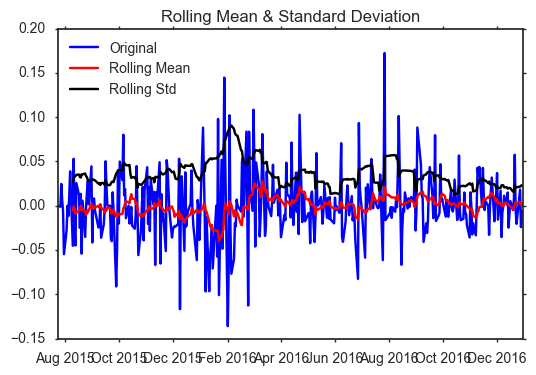

Results of Dickey-Fuller Test:
Test Statistic                -1.527699e+01
p-value                        4.633278e-28
#Lags Used                     1.000000e+00
Number of Observations Used    3.620000e+02
Critical Value (5%)           -2.869557e+00
Critical Value (1%)           -3.448544e+00
Critical Value (10%)          -2.571041e+00
dtype: float64


In [107]:
E_log_diff.dropna(inplace=True)
test_stationarity(E_log_diff)